In [44]:
import pandas as pd
### 竞争站点价格模型 ###
## 第一步：读取指定站点的销量、价格数据。 与整体销量、价格数据。

COLS_Y1= '销量（升）'
COLS_Y2= '价差'
COLS_X = '日期'
COLS_ALL = ['日期', '销量（升）', '石化站价格', '竞争站价格', '价差']

df_uncleaned = pd.read_csv('Data/竞争站23年全省.csv', usecols=COLS_ALL)
df_all = df_uncleaned.dropna()  # 删除包含空值的行
print(df_all.head())

df_single_uncleaned = pd.read_csv('Data/竞争站23年单站32809336.csv', usecols=COLS_ALL)
df_single = df_single_uncleaned.dropna()  # 删除包含空值的行
print(df_single.head())


           日期        销量（升）  石化站价格  竞争站价格    价差
3  2023-01-04  14719118.17   7.75   6.39  1.36
4  2023-01-05  15010279.85   7.75   6.39  1.36
5  2023-01-06  16382020.51   7.75   6.25  1.50
6  2023-01-07  16641259.84   7.75   6.25  1.50
7  2023-01-08  16673696.35   7.75   6.25  1.50
           日期   销量（升）  石化站价格  竞争站价格    价差
0  2023-07-17   40.06   7.63   7.19  0.44
1  2023-07-18    0.24   7.63   7.19  0.44
2  2023-07-19  239.41   7.63   7.19  0.44
3  2023-07-20  381.09   7.63   7.19  0.44
4  2023-07-21  553.67   7.63   7.19  0.44


In [45]:
## 第二步：把df_all中的部分行删除，只保留在df_single中有的相关日期。

# 将df_single中的日期列转换为列表
single_dates = df_single[COLS_X].drop_duplicates().tolist()

# 使用isin函数检查df_all中的日期是否在single_dates列表中
df_all = df_all[df_all[COLS_X].isin(single_dates)]

# 检查结果
print(df_all)

             日期        销量（升）  石化站价格  竞争站价格    价差
197  2023-07-17  19107927.06   7.63   6.48  1.15
198  2023-07-18  18554180.53   7.63   6.48  1.15
199  2023-07-19  18362961.85   7.63   6.58  1.05
200  2023-07-20  18679225.77   7.63   6.58  1.05
201  2023-07-21  19776171.20   7.63   6.58  1.05
..          ...          ...    ...    ...   ...
360  2023-12-27  17614287.55   7.51   6.28  1.23
361  2023-12-28  17571393.29   7.51   6.28  1.23
362  2023-12-29  20345903.28   7.51   6.28  1.23
363  2023-12-30  19210720.45   7.51   6.28  1.23
364  2023-12-31  20088115.17   7.51   6.28  1.23

[168 rows x 5 columns]


In [46]:
## 第三步：用最小二乘法找缩放倍数。
def find_scaling_factor(y, x):
    # 计算y和x的和的乘积
    sum_yx = sum(y_i * x_i for y_i, x_i in zip(y, x))
    # 计算y的平方和
    sum_y2 = sum(y_i ** 2 for y_i in y)
    # 计算缩放因子a
    a = sum_yx / sum_y2
    return a

# 给定的数据点
amountArray_df_all = df_all[COLS_Y1]
amountArray_df_single = df_single[COLS_Y1]

# 调用函数并打印结果
a = find_scaling_factor(amountArray_df_all, amountArray_df_single)
print(f"缩放倍数: {a}")
#The scaling factor a is: 4.779443260878052e-05 ~= 0.0000478

缩放倍数: 4.779443260878052e-05


In [47]:
import numpy as np

## 第四步：用缩放倍数缩放，得到该站点的销量波动残差
y = np.array(amountArray_df_all)
x = np.array(amountArray_df_single)

new_array = np.round((a * y - x), 2)
df_single['销量偏移值'] = new_array

print(df_single)


             日期    销量（升）  石化站价格  竞争站价格    价差   销量偏移值
0    2023-07-17    40.06   7.63   7.19  0.44  873.19
1    2023-07-18     0.24   7.63   7.19  0.44  886.55
2    2023-07-19   239.41   7.63   7.19  0.44  638.24
3    2023-07-20   381.09   7.63   7.19  0.44  511.67
4    2023-07-21   553.67   7.63   7.19  0.44  391.52
..          ...      ...    ...    ...   ...     ...
163  2023-12-27  1292.21   7.51   7.19  0.32 -450.35
164  2023-12-28   810.50   7.51   7.19  0.32   29.31
165  2023-12-29  1095.00   7.51   7.19  0.32 -122.58
166  2023-12-30   934.52   7.51   7.19  0.32  -16.35
167  2023-12-31   946.13   7.51   7.19  0.32   13.97

[168 rows x 6 columns]


C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


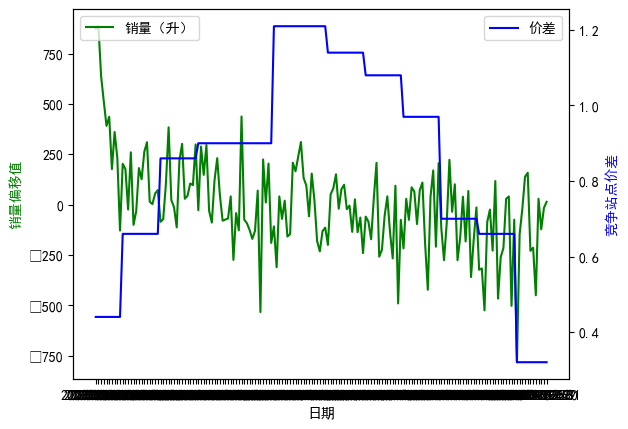

In [48]:
## 第五步：分析残差和价格的关系
import matplotlib.pyplot as plt

# 设置字体，确保能正确显示汉字
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体

# 创建一个图表和轴对象
fig, ax1 = plt.subplots()

# 绘制第一条曲线
ax1.plot(df_single[COLS_X], df_single['销量偏移值'], 'g-', label=COLS_Y1)
ax1.set_xlabel('日期')
ax1.set_ylabel('销量偏移值', color='g')

# 利用twinx()创建第二个Y轴
ax2 = ax1.twinx()

# 绘制第二条曲线
ax2.plot(df_single[COLS_X], df_single[COLS_Y2], 'b-', label=COLS_Y2)
ax2.set_ylabel('竞争站点价差', color='b')

# 显示图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 显示图表
plt.show()

(168,)
(168,)


C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


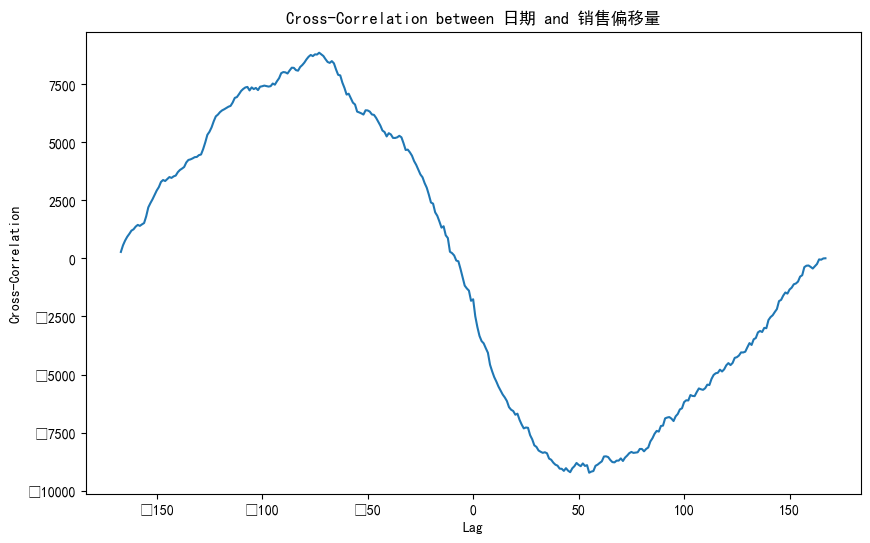

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# 计算交叉相关
x = df_single['销量偏移值']
y = df_single[COLS_Y2]
cross_corr = np.correlate(x, y, mode='full')

# 设置滞后
lags = np.arange(-len(x) + 1, len(y))

# 绘制交叉相关图
plt.figure(figsize=(10, 6))
plt.plot(lags, cross_corr)
plt.title("Cross-Correlation between "+COLS_X+" and "+"销售偏移量")
plt.xlabel("Lag")
plt.ylabel("Cross-Correlation")
plt.show()

In [56]:
## 第六步：计算标准化互相关值
x = df_single['销量偏移值']
y = df_single[COLS_Y2]

def norm_cross_corr(set1, set2):
    # python中求Normalized Cross Correlation的函数是: statsmodels.tsa.stattools.ccf
    return np.sum(set1 * set2) / (np.linalg.norm(set1) * np.linalg.norm(set2))

print(f"x和y标准化后的互相关值（-1,1)为: {norm_cross_corr(x, y)}")

x和y标准化后的互相关值（-1,1)为: -0.050986420274012435
